In [78]:
import pandas as pd
import numpy as np
import pygaze
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
import glob
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import detectors
import gazeplotter
from collections import defaultdict
# import local lib
import eye_metrics_utils
import data_utils
import gaze_entropy

In [79]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [80]:
def run_all(df_data):
    df_x = df_data.copy()
    if (data_utils.check_percentage_null(df_x) < 0.3): # if missing value > 30%, remove
        return None
    
    time = np.array(df_data['Start Time (secs)'].tolist())

    Efix = eye_metrics_utils.detect_fixations(df_x)
    Eblk = eye_metrics_utils.detect_blinks(df_x)
    Esac = eye_metrics_utils.detect_saccades(df_x)
    Emsac = eye_metrics_utils.detect_microsaccades(df_x)
#     print(Efix)
    X = np.array(Efix).T[3:].T
    Hs, Ht = gaze_entropy.entropy(X)
    total_time = time[-1] - time[0]
    
    return Efix, Hs, Ht, total_time, Eblk, Esac, Emsac
    

In [81]:
csv_files = glob.glob("data/*.csv")

In [82]:
csv_files_one = [v for v in csv_files if "One Gaze-Vergence" in v]
csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]
csv_files_three = [v for v in csv_files if "Three Go-Around Gaze-Vergence" in v]

# classification

In [83]:
df_par = pd.read_csv("participant.csv")
group = [df_par[df_par['Group'].str.contains("1")]['ID'].tolist(), df_par[df_par['Group'].str.contains("2")]["ID"].tolist()]
group = [[i[-3:] for i in v] for v in group]
group

[['032',
  '027',
  '031',
  '028',
  '004',
  '008',
  '010',
  '029',
  '003',
  '007',
  '023',
  '013',
  '024'],
 ['021',
  '006',
  '019',
  '022',
  '015',
  '016',
  '014',
  '005',
  '025',
  '002',
  '001',
  '020',
  '011',
  '017',
  '018',
  '026',
  '012',
  '009',
  '033']]

In [84]:
feature_groups = []
for g in group:
    trials = []
    for csv_files in [csv_files_one, csv_files_two, csv_files_three]:
#     for csv_files in [csv_files_two]:

        ret = defaultdict(list)
        for csv in csv_files:
            par_id = csv[14:17]
            if par_id not in g:
                continue
                
            df_data = pd.read_csv(csv)
            print(csv, len(df_data))

            for v in data_utils.data_slicing(df_data,  window_length = 1800, stride = 1800, min_length=1800):
                r = run_all(v)
                if r != None:
                    Efix, Hs, Ht, total_time, Eblk, Esac, Emsac = r
                    ret["Eblk"].append(Eblk)
                    ret["Efix"].append(Efix)
                    ret["Esac"].append(Esac)
                    ret["Emsac"].append(Emsac)
#                     ret["trans_matrix"].append(trans_matrix)
                    ret["Hs"].append(Hs)
                    ret["Ht"].append(Ht)
                    ret["total_time"].append(total_time)
        trials.append(ret)
    feature_groups.append(trials)

data\PISSS_ID_003_Approach One Gaze-Vergence.csv 9122
data\PISSS_ID_004_Approach One Gaze-Vergence.csv 9307
data\PISSS_ID_007_Approach One Gaze-Vergence.csv 9492
data\PISSS_ID_008_Approach One Gaze-Vergence.csv 9736
data\PISSS_ID_010_Approach One Gaze-Vergence.csv 9554
data\PISSS_ID_013_Approach One Gaze-Vergence.csv 8505
data\PISSS_ID_023_Approach One Gaze-Vergence.csv 9369
data\PISSS_ID_024_Approach One Gaze-Vergence.csv 9246
data\PISSS_ID_027_Approach One Gaze-Vergence.csv 9060
data\PISSS_ID_028_Approach One Gaze-Vergence.csv 8999
data\PISSS_ID_029_Approach One Gaze-Vergence.csv 9862
data\PISSS_ID_031_Approach One Gaze-Vergence.csv 9677
data\PISSS_ID_032_Approach One Gaze-Vergence.csv 8629
data\PISSS_ID_003_Approach Two Gaze-Vergence.csv 9368
data\PISSS_ID_004_Approach Two Gaze-Vergence.csv 9862
data\PISSS_ID_007_Approach Two Gaze-Vergence.csv 9677
data\PISSS_ID_008_Approach Two Gaze-Vergence.csv 9923
data\PISSS_ID_010_Approach Two Gaze-Vergence.csv 9923
data\PISSS_ID_013_Approach T

In [85]:
df_x = pd.DataFrame()
for j, g in enumerate(feature_groups):
    fix_dur = []
    for i, p in enumerate(g[1]['Efix']):
        fix_dur = np.append(fix_dur,np.mean(np.array(p).T[2]))
        
    Hs = g[1]['Hs']
    Ht = g[1]['Ht']
    
    fix_rate = np.array([len(v) for v in g[1]['Efix']])/np.array(g[1]['total_time'])
    blk_rate = np.array([len(v) for v in g[1]['Eblk']])/np.array(g[1]['total_time'])
    sac_rate = np.array([len(v) for v in g[1]['Esac']])/np.array(g[1]['total_time'])
    msac_rate = np.array([len(v) for v in g[1]['Emsac']])/np.array(g[1]['total_time'])

    print(len(fix_dur), len(fix_rate), len(sac_rate), len(blk_rate), len(msac_rate))
    group = j*np.ones_like(Hs)
    df = pd.DataFrame(zip(fix_dur, Hs, Ht, fix_rate, blk_rate, sac_rate, msac_rate, group), 
                        columns=["fix_dur", "Hs", "Ht", "fix_rate", "blk_rate", "sac_rate", "msac_rate", "group"]).astype({"group":"int"})
    df_x = pd.concat([df_x, df])
    
df_x


61 61 61 61 61
84 84 84 84 84


,fix_dur,Hs,Ht,fix_rate,blk_rate,sac_rate,msac_rate,group
0,0.592538,2.133797,1.486411,1.336189,0.308351,0.685225,1.918631,0
1,0.853206,1.949082,1.041519,0.822383,0.376926,0.788117,1.541969,0
2,0.655173,1.384432,1.123823,1.233531,0.308383,0.616765,1.610443,0
3,0.503358,1.530030,1.404720,1.130213,0.308240,0.958968,1.917937,0
4,0.598858,0.000000,0.000000,1.302284,0.171353,0.479789,1.884885,0
...,...,...,...,...,...,...,...,...
79,0.374869,1.943110,1.559071,0.890793,0.137045,0.753748,2.226983,1
80,0.576417,1.545153,0.716803,0.719535,0.034264,0.308372,1.439070,1
81,0.245442,0.000000,0.000000,0.239763,0.034252,0.102756,0.719289,1
82,0.746337,0.995727,0.794477,0.445506,0.822472,0.445506,0.822472,1


# classification models

In [86]:
len(df_x)

145

In [87]:
df_x.dtypes

fix_dur      float64
Hs           float64
Ht           float64
fix_rate     float64
blk_rate     float64
sac_rate     float64
msac_rate    float64
group          int32
dtype: object

In [88]:
df_x = df_x[~(df_x.iloc[:,:7] == 0).any(axis=1)]
len(df_x)

128

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [137]:
X = df_x[['fix_dur', 'Hs', 'Ht', "fix_rate", "blk_rate", "sac_rate", "msac_rate"]].values
# X = df_x[['fix_dur', "fix_rate"]].values

X = StandardScaler().fit_transform(X)

y = df_x[['group']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)

clf = LogisticRegression(random_state=1).fit(X_train, y_train)
# clf.predict(X_test)
clf.score(X_test, y_test)

0.59375

In [138]:
prob = clf.predict_proba(X_test)

In [139]:
thresh = 0.6

pred = []
for v in prob.T[1]:
    if v > thresh:
        pred.append(1)
    else:
        pred.append(0)

In [140]:
target_names = ['group 1', 'group 2']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     group 1       0.47      0.63      0.54        27
     group 2       0.64      0.49      0.55        37

    accuracy                           0.55        64
   macro avg       0.56      0.56      0.55        64
weighted avg       0.57      0.55      0.55        64



In [110]:
y_score = clf.decision_function(X_test)

In [111]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

ValueError: bad input shape (64, 2)

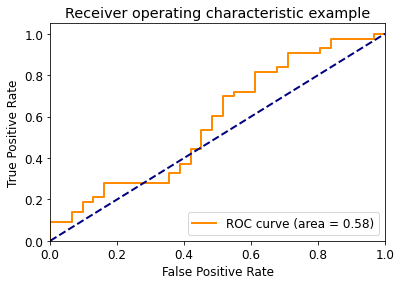

In [64]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [14]:
features = ['fix_dur', 'Hs', 'Ht', "fix_rate", "blk_rate", "sac_rate", "msac_rate"]
print(clf.classes_)
for i in range(len(features)):
    print(features[i] + "      \t: " + str(round(clf.coef_[0][i],3)))

[0 1]
fix_dur      	: -0.571
Hs      	: -0.255
Ht      	: -0.1
fix_rate      	: 1.016
blk_rate      	: -0.922
sac_rate      	: -0.827
msac_rate      	: -0.458


In [ ]:
y_pred = clf.predict(X_test)
target_names = ['group 1', 'group 2']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
y_score = clf.decision_function(X_test)

In [ ]:
print("AUC: ", roc_auc_score(y_test, y_score))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [92]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [93]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Nearest Neighbors
AUC:  0.5529411764705882
              precision    recall  f1-score   support

     group 1       0.50      0.60      0.55        30
     group 2       0.57      0.47      0.52        34

    accuracy                           0.53        64
   macro avg       0.54      0.54      0.53        64
weighted avg       0.54      0.53      0.53        64

Linear SVM
AUC:  0.6147058823529412
              precision    recall  f1-score   support

     group 1       1.00      0.03      0.06        30
     group 2       0.54      1.00      0.70        34

    accuracy                           0.55        64
   macro avg       0.77      0.52      0.38        64
weighted avg       0.76      0.55      0.40        64

RBF SVM
AUC:  0.6490196078431373
              precision    recall  f1-score   support

     group 1       0.56      0.93      0.70        30
     group 2       0.86      0.35      0.50        34

    accuracy                           0.62        64
   macro avg    

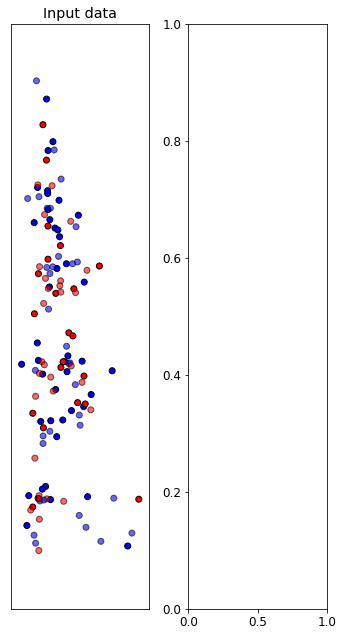

In [113]:
figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    
    
    if hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
        
    
    thresh = 0.6

    pred = []
    for v in y_score:
        if v > thresh:
            pred.append(1)
        else:
            pred.append(0)
    

    print(name)
    print("AUC: ", roc_auc_score(y_test, y_score))
    target_names = ['group 1', 'group 2']
    print(classification_report(y_test, pred, target_names=target_names))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     else:
#         Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#     # Plot the training points
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                edgecolors='k')
#     # Plot the testing points
#     ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
#                edgecolors='k', alpha=0.6)

#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     ax.set_title(name)
#     ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#             size=15, horizontalalignment='right')
#     i += 1

plt.tight_layout()
plt.show()

In [ ]:
a = [[1,3,4,5,6,2,1,3,5,2,3,1],[1,2,3,1,2,3,4,5,3,2,2,3]]

a = StandardScaler().fit_transform(a)